We will define strategies and do backtests for all selected pairs for '1D' & '1H' resolutions.
A summary pdf report will be printed in the end.

In [202]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn
import dataframe_image as dfi
import math

# define report path
Path("report").mkdir(parents=True, exist_ok=True)

### SETUP

In [203]:
resolution_list = ['1D','1H']

# report_heading = "Utilities 1Y"  # change for the report heading
report_heading = "BANKS 1Y"  # change for the report heading

pos_value = 7500 # x2 for pair buy & sell
mar_req = 0.3 # margin requirement
cash_req = mar_req * pos_value * 2 # required cash
avg_slip = 0.001 # per order per position value
avg_commission = 0.007 # per contract

avg_fin_cost_dic = {'1D':(0.07/365),'1H':(0.07/365/7)} # per borrowed cash per day&hour

### GET PAIR INFORMATION

In [204]:
max_items = 24
pairs_dic_filtered = {}

with open('pairs_final.pkl', 'rb') as f:
    pairs_dic = pickle.load(f)

i = 0
for key,item in pairs_dic.items():
    if i<max_items:
        i = i+1
        pairs_dic_filtered[key] = item
        
pairs_dic = pairs_dic_filtered
pairs_dic

{('COF', 'USB'): 0.43,
 ('MS', 'STT'): 0.82,
 ('BEN', 'KKR'): 1.98,
 ('RF', 'STT'): 3.23,
 ('CG', 'USB'): 1.42,
 ('APO', 'C'): 0.89,
 ('BAM', 'TW'): 1.42,
 ('CADE', 'STT'): 2.61,
 ('APO', 'STT'): 1.26,
 ('BX', 'USB'): 0.48,
 ('CADE', 'MS'): 3.19,
 ('CG', 'JHG'): 0.74,
 ('RF', 'SCHW'): 3.34,
 ('APO', 'BEN'): 0.46,
 ('BAC', 'STT'): 2.03,
 ('BX', 'JHG'): 0.25}

In [205]:
max_drop_items = 10
drop_dic_filtered = {}

with open('pairs_dropped.pkl', 'rb') as f:
    drop_dic = pickle.load(f)  
drop_dic

i = 0
for key,item in drop_dic.items():
    if i<max_drop_items:
        i = i+1
        drop_dic_filtered[key] = item
        
drop_dic = drop_dic_filtered
drop_dic

{('BX', 'CG'): 0.33,
 ('BX', 'TW'): 0.69,
 ('BX', 'COF'): 1.1,
 ('KKR', 'TROW'): 2.35,
 ('CADE', 'SCHW'): 2.7}

### DEFINE STRATEGIES

In [206]:
# buy and sell at upper and lower bollinger band, exit at sma
def exit_sma(data, lower_bb, upper_bb, sma_20, _):
    buy_price = []
    sell_price = []
    bb_signal = []
    position = []
    signal = 0
      
    position = [0] * len(data)
      
    for i in range(len(data)):
        # define band crossings
        if data[i - 1] > lower_bb[i - 1] and data[i] < lower_bb[i]:
            if position[i-1] == 0:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < upper_bb[i - 1] and data[i] > upper_bb[i]:
            if position[i-1] == 0:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = -1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        # define sma crossings
        elif data[i - 1] > sma_20[i - 1] and data[i] < sma_20[i]:
            if position[i-1] != 0:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 0
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < sma_20[i - 1] and data[i] > sma_20[i]:
            if position[i-1] != 0:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = 0
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            position[i] = position[i-1]

    return buy_price, sell_price, bb_signal, position


# buy and sell at upper and lower bollinger band, keep position, no exit
def no_exit(data, lower_bb, upper_bb, *_):

    buy_price = []
    sell_price = []
    bb_signal = []
    position = []
    signal = 0
           
    position = [0] * len(data)
    
    for i in range(len(data)):
        if data[i - 1] > lower_bb[i - 1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < upper_bb[i - 1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = -1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            position[i] = position[i-1]

    return buy_price, sell_price, bb_signal, position


# buy and sell at upper and lower bollinger band, exit at sma, no exit if moving towards n days-sma
def skp_sma(data, lower_bb, upper_bb, sma_20, sma_nd):
    buy_price = []
    sell_price = []
    bb_signal = []
    position = []
    signal = 0
      
    position = [0] * len(data)
      
    for i in range(len(data)):
        # define band crossings
        if data[i - 1] > lower_bb[i - 1] and data[i] < lower_bb[i]:
            if position[i-1] != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < upper_bb[i - 1] and data[i] > upper_bb[i]:
            if position[i-1] != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = -1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        # define sma crossings
        elif data[i - 1] > sma_20[i - 1] and data[i] < sma_20[i]:
            if data[i] < sma_nd[i]: # check 20d-sma
                if position[i-1] == -1:
                    buy_price.append(data[i])
                    sell_price.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                    position[i] = 0
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    bb_signal.append(0)
                    position[i] = position[i-1]
                    
            else: # moving towards 20d-sma               
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
                
                
        elif data[i - 1] < sma_20[i - 1] and data[i] > sma_20[i]:
            if data[i] > sma_nd[i]: # check 20d-sma
                if position[i-1] == 1:
                    buy_price.append(np.nan)
                    sell_price.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                    position[i] = 0
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    bb_signal.append(0)
                    position[i] = position[i-1]
                    
            else: # moving towards 20d-sma               
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            position[i] = position[i-1]

    return buy_price, sell_price, bb_signal, position

### DEFINE SMA & BOLLINGER FUNCTIONS

In [207]:
def sma(values, n):
    return pd.Series(values).rolling(n).mean()

def bb(data, sma, sd=2.0, n=20):
    std = data.rolling(n).std(ddof=1) # default ddof=1, sample standard deviation, divide by (n-1)
    bb_up = sma + std * sd
    bb_low = sma - std * sd
    return bb_up, bb_low

### CALCULATE STRATEGY RETURNS

Define function

In [208]:
def calculate_returns(data_dic, str_list, b=2):  # b is 1.0, 1.5, 2.0, 2.5 or 3 std

    # list of strategies to apply
    strategy_list = str_list

    # create a dataframe to fill with strategy return values
    df = pd.DataFrame.from_dict(data_dic, orient="index")
    returns_df = df.iloc[:, 1:]  # drop the first column
    returns_with_costs_df = df.iloc[:, 1:]  # drop the first column

    for res in resolution_list:

        for st in range(len(strategy_list)):
            apply_strategy = globals()[strategy_list[st]]

            returns_list = []
            costs_list = []

            for key in data_dic:
                ticker1 = key[0]
                ticker2 = key[1]
                hedge = data_dic[key]
                # print(f"EQUATION: {ticker2}={hedge}*{ticker1}")

                # read data from csv
                alltickersfile = "data/tickers_" + res + ".csv"
                df = pd.read_csv(alltickersfile)
                df_sorted = df.set_index(["ticker", "time"]).sort_index()  # set indexes
                df1 = df_sorted.xs(ticker1)  # the first ticker
                df2 = df_sorted.xs(ticker2)  # the second ticker

                # calculate spread
                df1_1 = hedge * df1
                df_spread = df2.subtract(df1_1).round(5)

                # add sma & bollinger bands
                df_spread["sma_20"] = sma(df_spread.Close, 20)
                
                if res == '1D':                 
                    df_spread['sma_50d']=sma(df_spread.Close, 50) # add 50d sma for 1D resolution
                
                else:
                    df_spread['sma_20d']=sma(df_spread.Close, 20*7) # add 20d sma for 1H resolution
                
                for i in range(2, 7):
                    step = 0.5
                    b_band = round(step*i,1)
                    (
                        df_spread["bb_up_" + str(b_band)],
                        df_spread["bb_low_" + str(b_band)],
                    ) = bb(df_spread["Close"], df_spread["sma_20"], b_band, 20)

                df_spread_bb = df_spread.copy()
                df_spread_bb = df_spread_bb.dropna()

                # apply strategy & positions
                
                if res == '1D':               
                    buy_price, sell_price, signal, position = apply_strategy(
                        df_spread_bb["Close"],
                        df_spread_bb["bb_low_" + str(round(b,1))],
                        df_spread_bb["bb_up_" + str(round(b,1))],
                        df_spread_bb["sma_20"],
                        df_spread_bb["sma_50d"]
                    )
                else:                       
                    buy_price, sell_price, signal, position = apply_strategy(
                        df_spread_bb["Close"],
                        df_spread_bb["bb_low_" + str(round(b,1))],
                        df_spread_bb["bb_up_" + str(round(b,1))],
                        df_spread_bb["sma_20"],
                        df_spread_bb["sma_20d"]
                    )
                        
                signal_df = (
                    pd.DataFrame(signal)
                    .rename(columns={0: "signal"})
                    .set_index(df_spread_bb.index)
                )
                position_df = (
                    pd.DataFrame(position)
                    .rename(columns={0: "bb_position"})
                    .set_index(df_spread_bb.index)
                )

                # calculate price difference per bar
                df_spread_bb_ret = pd.DataFrame(np.diff(df_spread_bb["Close"])).rename(
                    columns={0: "returns"}
                )

                # calculate return per bar
                bb_strategy_ret = []
                for i in range(len(df_spread_bb_ret)):
                    try:
                        returns = (
                            df_spread_bb_ret["returns"][i]
                            * position_df["bb_position"][i]
                        )
                        bb_strategy_ret.append(returns)
                    except:
                        pass

                bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(
                    columns={0: "bb_returns"}
                )

                # calculate investment return
                contract_price = round(df2.iloc[-1,df2.columns.get_loc('Close')],0) # get the latest price
                number_of_stocks = math.floor(pos_value / contract_price)
                bb_investment_ret = []

                for i in range(len(bb_strategy_ret_df["bb_returns"])):
                    returns = number_of_stocks * bb_strategy_ret_df["bb_returns"][i]
                    bb_investment_ret.append(returns)

                bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(
                    columns={0: "investment_returns"}
                )
                total_investment_ret = round(
                    sum(bb_investment_ret_df["investment_returns"]), 2
                )
                profit_percentage = math.floor((total_investment_ret / cash_req) * 100)

                returns_list.append(profit_percentage)

                slip = signal_df.signal.abs() * avg_slip * pos_value
                commission = signal_df.signal.abs() * avg_commission * number_of_stocks * 2
                fincost = (
                    position_df.bb_position.abs()
                    * avg_fin_cost_dic[res]
                    * (2 * pos_value - cash_req)
                )

                total_cost = (
                    slip.sum().round(1)
                    + commission.sum().round(1)
                    + fincost.sum().round(1)
                )

                total_investment_ret_cost = (
                    round(sum(bb_investment_ret_df["investment_returns"]), 2)
                    - total_cost
                )
                profit_percentage_cost = math.floor(
                    (total_investment_ret_cost / cash_req) * 100
                )

                costs_list.append(profit_percentage_cost)

            returns_df[res + "_" + strategy_list[st]] = returns_list
            returns_with_costs_df[res + "_" + strategy_list[st]] = costs_list

    return returns_df, returns_with_costs_df

Run and display results

average return - 1D_exit_sma : 38.5%
average return - 1D_no_exit : 45.81%
average return - 1H_exit_sma : -2.12%
average return - 1H_no_exit : 7.62%
average return (costs included) - 1D_exit_sma : 32.38%
average return (costs included) - 1D_no_exit : 36.5%
average return (costs included) - 1H_exit_sma : -29.81%
average return (costs included) - 1H_no_exit : -9.62%


,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
"('APO', 'C')",88,137,46,57
"('BAC', 'STT')",53,51,34,79
"('APO', 'STT')",38,36,48,68
"('CG', 'USB')",55,113,-16,20
"('RF', 'SCHW')",34,64,29,18
"('BX', 'USB')",98,31,-38,31
"('COF', 'USB')",40,23,-4,62
"('APO', 'BEN')",38,4,52,19
"('MS', 'STT')",29,25,23,32
"('CG', 'JHG')",57,91,-35,-6


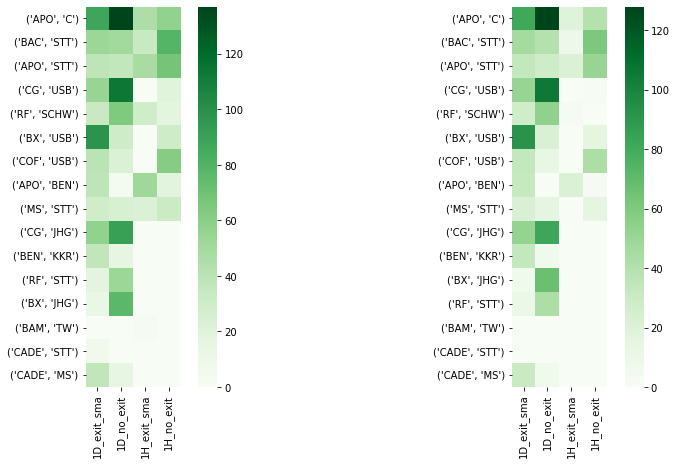

In [209]:
from IPython.display import display_html 

#strategy_list = ["exit_sma", "no_exit", "skp_sma"]
str_list = ["exit_sma", "no_exit"]

df1_2_0std, df2_2_0std = calculate_returns(pairs_dic, str_list, b=2.0) # b is 1.0, 1.5, 2.0, 2.5 or 3 std

for col in df1_2_0std.columns:
    print(f"average return - {col} : {round(df1_2_0std[col].mean(),2)}%")

for col in df2_2_0std.columns:
    print(f"average return (costs included) - {col} : {round(df2_2_0std[col].mean(),2)}%")
    
df1_sort = df1_2_0std.copy()
df2_sort = df2_2_0std.copy()
df1_sort['mean'] = df1_2_0std.mean(axis=1)
df1_sort = df1_sort.sort_values('mean', ascending=False)
df2_sort['mean'] = df2_2_0std.mean(axis=1)
df2_sort = df2_sort.sort_values('mean', ascending=False)
df1_sort = df1_sort.drop(columns=['mean'])
df2_sort = df2_sort.drop(columns=['mean'])

df1_style = df1_sort.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("2DEV Return%")
df2_style = df2_sort.style.set_table_attributes("style='display:inline'").set_caption(" 2DEV Return% (costs inc.)")

display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))
# fig.tight_layout()
seaborn.heatmap(
    df1_sort,
    xticklabels=df1_sort.columns,
    yticklabels=df1_sort.index,
    cmap="Greens",
    square=True,
    vmin=0,
    ax=ax1
)

seaborn.heatmap(
    df2_sort,
    xticklabels=df2_sort.columns,
    yticklabels=df2_sort.index,
    cmap="Greens",
    square=True,
    vmin=0,
    ax=ax2
)

dpi_set=100
dfi.export(df1_style, 'summary1.png', dpi=dpi_set)
dfi.export(df2_style, 'summary2.png', dpi=dpi_set)
plt.savefig('summary_plot1', dpi=dpi_set, bbox_inches='tight', pad_inches=0)


average return - 1D_exit_sma : 20.4%
average return - 1D_no_exit : 56.0%
average return - 1H_exit_sma : 16.4%
average return - 1H_no_exit : 2.0%
average return (costs included) - 1D_exit_sma : 13.2%
average return (costs included) - 1D_no_exit : 46.2%
average return (costs included) - 1H_exit_sma : -7.8%
average return (costs included) - 1H_no_exit : -13.6%


,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
"('CADE', 'SCHW')",27,82,2,5
"('KKR', 'TROW')",27,59,-15,32
"('BX', 'CG')",-1,7,69,27
"('BX', 'TW')",-25,68,-29,66
"('BX', 'COF')",74,64,55,-120
,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
"('CADE', 'SCHW')",21,73,-24,-13
"('BX', 'CG')",-10,-3,43,12
"('KKR', 'TROW')",20,49,-43,14
"('BX', 'COF')",68,54,36,-132


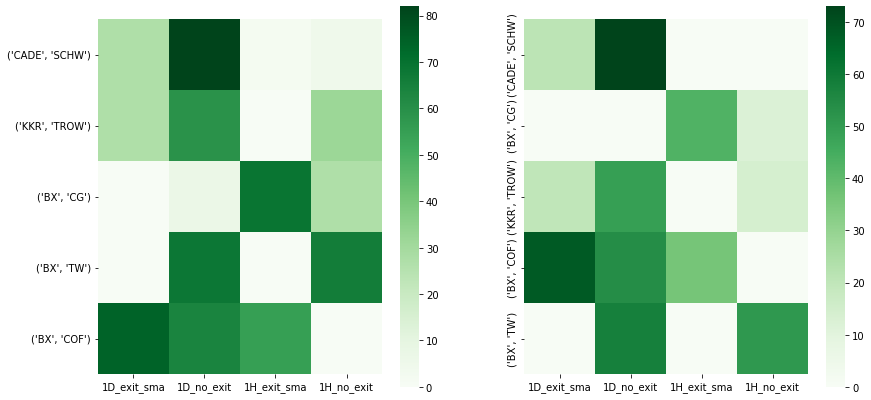

In [210]:
if bool(drop_dic):
    
    df1_drop, df2_drop = calculate_returns(drop_dic, str_list, b=2.0) # b is 1,2 or 3 std

    for col in df1_drop.columns:
        print(f"average return - {col} : {round(df1_drop[col].mean(),2)}%")

    for col in df2_drop.columns:
        print(f"average return (costs included) - {col} : {round(df2_drop[col].mean(),2)}%")

    df1_drop_sort = df1_drop.copy()
    df2_drop_sort = df2_drop.copy()
    df1_drop_sort['mean'] = df1_drop.mean(axis=1)
    df1_drop_sort = df1_drop_sort.sort_values('mean', ascending=False)
    df2_drop_sort['mean'] = df2_drop.mean(axis=1)
    df2_drop_sort = df2_drop_sort.sort_values('mean', ascending=False)
    df1_drop_sort = df1_drop_sort.drop(columns=['mean'])
    df2_drop_sort = df2_drop_sort.drop(columns=['mean'])

    df1_style_drop = df1_drop_sort.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("Return%")
    df2_style_drop = df2_drop_sort.style.set_table_attributes("style='display:inline'").set_caption("Return% (costs inc.)")


    display_html(df1_style_drop._repr_html_() + df2_style_drop._repr_html_(), raw=True)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))
    seaborn.heatmap(
        df1_drop_sort,
        xticklabels=df1_drop_sort.columns,
        yticklabels=df1_drop_sort.index,
        cmap="Greens",
        square=True,
        vmin=0,
        ax=ax1
    )
    seaborn.heatmap(
        df2_drop_sort,
        xticklabels=df2_drop_sort.columns,
        yticklabels=df2_drop_sort.index,
        cmap="Greens",
        square=True,
        vmin=0,
        ax=ax2
    )

    # dpi_set=100
    # dfi.export(df1_style_drop, 'summary1_drop.png', dpi=dpi_set)
    # dfi.export(df2_style_drop, 'summary2_drop.png', dpi=dpi_set)
    # plt.savefig('summary_plot1_drop', dpi=dpi_set, bbox_inches='tight', pad_inches=0)

### EXERCISE : Calculate all strategies from 1 std to 3 std dev

Calculate returns

In [211]:
str_list = ["exit_sma", "no_exit", "skp_sma"]

df1_1_0std, df2_1_0std = calculate_returns(pairs_dic,str_list,b=1.0)
df1_1_5std, df2_1_5std = calculate_returns(pairs_dic,str_list,b=1.5)
df1_2_0std, df2_2_0std = calculate_returns(pairs_dic,str_list,b=2.0)
df1_2_5std, df2_2_5std = calculate_returns(pairs_dic,str_list,b=2.5)
df1_3_0std, df2_3_0std = calculate_returns(pairs_dic,str_list,b=3.0)

df2_1_0std['bb'] = 1.0
df2_1_5std['bb'] = 1.5
df2_2_0std['bb'] = 2.0
df2_2_5std['bb'] = 2.5
df2_3_0std['bb'] = 3.0
df2_all = pd.concat([df2_1_0std,df2_1_5std,df2_2_0std,df2_2_5std,df2_3_0std])

df2_all.head()

,1D_exit_sma,1D_no_exit,1D_skp_sma,1H_exit_sma,1H_no_exit,1H_skp_sma,bb
"(COF, USB)",1,51,45,-28,14,16,1.0
"(MS, STT)",-8,47,42,-57,-27,-36,1.0
"(BEN, KKR)",65,133,115,-65,-100,-80,1.0
"(RF, STT)",-17,35,11,-74,-67,-73,1.0
"(CG, USB)",43,45,14,-35,-34,-58,1.0


Group by bb band

In [212]:
df2_all1 = df2_all.copy()
df2_all1 = df2_all1.reset_index()
df2_all1 = df2_all1.rename(columns={"index": "pair"})
df2_all1 = df2_all1.set_index(['bb','pair']).sort_index()
df2_all1.tail()

1D_exit_sma  1D_no_exit  1D_skp_sma  1H_exit_sma  1H_no_exit  \
bb  pair                                                                       
3.0 (CG, USB)            35          65          36           -8          23   
    (COF, USB)           11           9          11            9          -9   
    (MS, STT)            -9          -7         -14           -1         -24   
    (RF, SCHW)          -14          -6         -15          -25         -13   
    (RF, STT)           -20         -37         -31          -19         -37   

                1H_skp_sma  
bb  pair                    
3.0 (CG, USB)           41  
    (COF, USB)          43  
    (MS, STT)          -10  
    (RF, SCHW)         -17  
    (RF, STT)           12

Slice & Add level by std. dev

In [213]:
df2_list =[]
df2_sort =[]
df2_sort_leveled =[]

for i in range(2,7):
    step = 0.5
    b_band = round(step*i,1)
    df2_list.append(df2_all1.xs((b_band,))) 
    
for i in range(len(df2_list)):
    df2_sort.append(df2_list[i])
    df2_sort[i]['mean'] = df2_list[i].mean(axis=1).round(1)
    df2_sort[i] = df2_sort[i].sort_values('mean', ascending=False)
    mean_cols = df2_list[i].mean(axis=0).round(1)
    df2_sort[i].loc["avg"] = mean_cols
    df2_nomean= df2_sort[i].loc[ : , df2_sort[i].columns != 'mean']
    df2_nomean = df2_nomean.sort_values('avg', axis=1, ascending=False)
    df2_nomean['mean'] = df2_sort[i]['mean']
    df2_sort[i] = df2_nomean
    df2_sort_leveled.append(pd.concat([df2_sort[i]], keys=[str(i/2+1) + ' DEV RETURN%'], axis=1))


Show dataframes

In [214]:
df2_std1_0leveled = df2_sort_leveled[0]
df2_std1_5leveled = df2_sort_leveled[1]
df2_std2_0leveled = df2_sort_leveled[2]
df2_std2_5leveled = df2_sort_leveled[3]
df2_std3_0leveled = df2_sort_leveled[4]


std1_0style = df2_std1_0leveled.style.set_table_attributes("style='display:inline; margin-right:20px;'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std1_5style = df2_std1_5leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std2_0style = df2_std2_0leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std2_5style = df2_std2_5leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std3_0style = df2_std3_0leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

display_html(std1_0style._repr_html_() + std1_5style._repr_html_() + std2_0style._repr_html_() + std2_5style._repr_html_() + std3_0style._repr_html_(), raw=True)

1.0 DEV RETURN% 
 
 
   
 1D_no_exit 
 1D_skp_sma 
 1D_exit_sma 
 1H_skp_sma 
 1H_no_exit 
 1H_exit_sma 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('APO', 'STT') 
 81.0 
 108.0 
 54.0 
 78.0 
 62.0 
 50.0 
 72.2 
 
 
 ('APO', 'C') 
 145.0 
 121.0 
 60.0 
 -19.0 
 -13.0 
 8.0 
 50.3 
 
 
 ('BX', 'USB') 
 179.0 
 200.0 
 119.0 
 -84.0 
 -88.0 
 -44.0 
 47.0 
 
 
 ('APO', 'BEN') 
 24.0 
 51.0 
 77.0 
 38.0 
 32.0 
 6.0 
 38.0 
 
 
 ('CG', 'JHG') 
 110.0 
 86.0 
 44.0 
 -4.0 
 -13.0 
 5.0 
 38.0 
 
 
 ('BAC', 'STT') 
 21.0 
 41.0 
 33.0 
 15.0 
 29.0 
 34.0 
 28.8 
 
 
 ('COF', 'USB') 
 51.0 
 45.0 
 1.0 
 16.0 
 14.0 
 -28.0 
 16.5 
 
 
 ('BEN', 'KKR') 
 133.0 
 115.0 
 65.0 
 -80.0 
 -100.0 
 -65.0 
 11.3 
 
 
 ('BX', 'JHG') 
 105.0 
 103.0 
 29.0 
 -32.0 
 -57.0 
 -145.0 
 0.5 
 
 
 ('CG', 'USB') 
 45.0 
 14.0 
 43.0 
 -58.0 
 -34.0 
 -35.0 
 -4.2 
 
 
 ('RF', 'SCHW') 
 30.0 
 29.0 
 -4.0 
 -39.0 
 -36.0 
 -12.0 
 -5.3 
 
 
 ('MS', 'STT') 
 47.0 
 42.0 
 -8.0 
 -36.0 
 -27.0 
 -57.0 
 -6.5 
 
 
 ('BAM', 'TW') 
 -24.0 
 -20.0 
 -28.0 
 -28.0 
 -3.0 
 -39.0 
 -23.7 
 
 
 ('CADE', 'MS') 
 17.0 
 27.0 
 -8.0 
 -80.0 
 -81.0 
 -58.0 
 -30.5 
 
 
 ('RF', 'STT') 
 35.0 
 11.0 
 -17.0 
 -73.0 
 -67.0 
 -74.0 
 -30.8 
 
 
 ('CADE', 'STT') 
 41.0 
 29.0 
 28.0 
 -91.0 
 -106.0 
 -100.0 
 -33.2 
 
 
 avg 
 65.0 
 62.6 
 30.5 
 -29.8 
 -30.5 
 -34.6 
 10.5 
 
 
 

 
 
 
   
 1.5 DEV RETURN% 
 
 
   
 1D_no_exit 
 1D_skp_sma 
 1D_exit_sma 
 1H_skp_sma 
 1H_no_exit 
 1H_exit_sma 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('APO', 'STT') 
 72.0 
 83.0 
 90.0 
 101.0 
 78.0 
 29.0 
 75.5 
 
 
 ('CG', 'JHG') 
 149.0 
 117.0 
 81.0 
 31.0 
 37.0 
 34.0 
 74.8 
 
 
 ('BX', 'USB') 
 189.0 
 217.0 
 129.0 
 -57.0 
 -47.0 
 -100.0 
 55.2 
 
 
 ('CG', 'USB') 
 125.0 
 80.0 
 117.0 
 11.0 
 36.0 
 -45.0 
 54.0 
 
 
 ('APO', 'C') 
 65.0 
 89.0 
 68.0 
 -2.0 
 9.0 
 46.0 
 45.8 
 
 
 ('BAC', 'STT') 
 57.0 
 58.0 
 48.0 
 40.0 
 50.0 
 -3.0 
 41.7 
 
 
 ('APO', 'BEN') 
 23.0 
 50.0 
 49.0 
 40.0 
 9.0 
 -3.0 
 28.0 
 
 
 ('BEN', 'KKR') 
 112.0 
 117.0 
 86.0 
 -47.0 
 -81.0 
 -33.0 
 25.7 
 
 
 ('COF', 'USB') 
 40.0 
 46.0 
 17.0 
 30.0 
 30.0 
 -19.0 
 24.0 
 
 
 ('MS', 'STT') 
 53.0 
 45.0 
 21.0 
 -12.0 
 -6.0 
 -26.0 
 12.5 
 
 
 ('RF', 'SCHW') 
 58.0 
 43.0 
 24.0 
 -29.0 
 -35.0 
 -68.0 
 -1.2 
 
 
 ('BX', 'JHG') 
 104.0 
 82.0 
 17.0 
 -41.0 
 -61.0 
 -112.0 
 -1.8 
 
 
 ('CADE', 'STT') 
 44.0 
 38.0 
 33.0 
 -57.0 
 -82.0 
 -66.0 
 -15.0 
 
 
 ('BAM', 'TW') 
 1.0 
 -3.0 
 -31.0 
 -8.0 
 -6.0 
 -61.0 
 -18.0 
 
 
 ('RF', 'STT') 
 9.0 
 1.0 
 3.0 
 -58.0 
 -63.0 
 -72.0 
 -30.0 
 
 
 ('CADE', 'MS') 
 -21.0 
 6.0 
 3.0 
 -70.0 
 -78.0 
 -64.0 
 -37.3 
 
 
 avg 
 67.5 
 66.8 
 47.2 
 -8.0 
 -13.1 
 -35.2 
 20.9 
 
 
 

 
 
 
   
 2.0 DEV RETURN% 
 
 
   
 1D_skp_sma 
 1D_no_exit 
 1D_exit_sma 
 1H_skp_sma 
 1H_no_exit 
 1H_exit_sma 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('APO', 'C') 
 102.0 
 128.0 
 81.0 
 44.0 
 40.0 
 19.0 
 69.0 
 
 
 ('APO', 'STT') 
 46.0 
 28.0 
 33.0 
 61.0 
 51.0 
 21.0 
 40.0 
 
 
 ('BAC', 'STT') 
 38.0 
 40.0 
 46.0 
 36.0 
 61.0 
 8.0 
 38.2 
 
 
 ('BX', 'USB') 
 92.0 
 22.0 
 92.0 
 18.0 
 16.0 
 -60.0 
 30.0 
 
 
 ('CG', 'USB') 
 65.0 
 105.0 
 51.0 
 -7.0 
 1.0 
 -46.0 
 28.2 
 
 
 ('RF', 'SCHW') 
 49.0 
 54.0 
 27.0 
 -5.0 
 0.0 
 2.0 
 21.2 
 
 
 ('COF', 'USB') 
 29.0 
 13.0 
 33.0 
 28.0 
 43.0 
 -32.0 
 19.0 
 
 
 ('APO', 'BEN') 
 12.0 
 -4.0 
 32.0 
 50.0 
 2.0 
 21.0 
 18.8 
 
 
 ('CG', 'JHG') 
 74.0 
 82.0 
 52.0 
 -9.0 
 -25.0 
 -65.0 
 18.2 
 
 
 ('MS', 'STT') 
 32.0 
 15.0 
 22.0 
 18.0 
 15.0 
 -7.0 
 15.8 
 
 
 ('BEN', 'KKR') 
 47.0 
 6.0 
 33.0 
 7.0 
 -29.0 
 -57.0 
 1.2 
 
 
 ('BX', 'JHG') 
 43.0 
 67.0 
 7.0 
 -38.0 
 -91.0 
 -53.0 
 -10.8 
 
 
 ('RF', 'STT') 
 16.0 
 43.0 
 11.0 
 -49.0 
 -62.0 
 -68.0 
 -18.2 
 
 
 ('CADE', 'STT') 
 -19.0 
 -10.0 
 0.0 
 -24.0 
 -59.0 
 -47.0 
 -26.5 
 
 
 ('CADE', 'MS') 
 28.0 
 7.0 
 31.0 
 -68.0 
 -75.0 
 -86.0 
 -27.2 
 
 


In [215]:
dpi_set=100
dfi.export(std1_0style, 'table1.png', dpi=dpi_set)
dfi.export(std1_5style, 'table2.png', dpi=dpi_set)
dfi.export(std2_0style, 'table3.png', dpi=dpi_set)
dfi.export(std2_5style, 'table4.png', dpi=dpi_set)
dfi.export(std3_0style, 'table5.png', dpi=dpi_set)

Get col. values

In [216]:
df2_sort_leveled[2][('2.0 DEV RETURN%', '1D_exit_sma')]

pair
(APO, C)       81.0
(APO, STT)     33.0
(BAC, STT)     46.0
(BX, USB)      92.0
(CG, USB)      51.0
(RF, SCHW)     27.0
(COF, USB)     33.0
(APO, BEN)     32.0
(CG, JHG)      52.0
(MS, STT)      22.0
(BEN, KKR)     33.0
(BX, JHG)       7.0
(RF, STT)      11.0
(CADE, STT)     0.0
(CADE, MS)     31.0
(BAM, TW)     -33.0
avg            32.4
Name: (2.0 DEV RETURN%, 1D_exit_sma), dtype: float64

Get index values

In [217]:
# df2_all1.xs((1,('LNT', 'NEE')))

Average returns by selected standard deviation

In [218]:
df2_all1.groupby(["bb"]).mean()

,1D_exit_sma,1D_no_exit,1D_skp_sma,1H_exit_sma,1H_no_exit,1H_skp_sma
bb,,,,,,
1.0,30.5000,65.00,62.6250,-34.6250,-30.500,-29.8125
1.5,47.1875,67.50,66.8125,-35.1875,-13.125,-8.0000
2.0,32.3750,36.50,39.3750,-29.8125,-9.625,2.2500
2.5,19.0000,12.00,18.6875,-15.8125,5.625,19.3125
3.0,3.7500,2.75,3.4375,-6.3125,-5.250,12.4375


Mean,Max,Min by selected standard deviation

In [219]:
df2_all1.groupby(["bb"]).agg({"1H_no_exit": ["mean", "max", "min"]})

1H_no_exit         
          mean max  min
bb                     
1.0    -30.500  62 -106
1.5    -13.125  78  -82
2.0     -9.625  61  -91
2.5      5.625  74  -84
3.0     -5.250  50  -65

### EXERCISE : PRINT TO PDF

In [220]:
import fpdf
from fpdf import FPDF
import time
from PIL import Image

#find the table size
im = Image.open("summary1.png")

#image size
width_table = im.size[0]*(25.4/dpi_set) #converted to approx mm
height_table = im.size[1]*(25.4/dpi_set) #converted to approx mm

def write_big(pdf, words):
    
    # Set text colour, font size, and font type
    pdf.set_text_color(r=0,g=0,b=0)
    pdf.set_font('Helvetica', '', 12)
    
    pdf.write(5, words)
    
def write_small(pdf, words):
    
    # Set text colour, font size, and font type
    pdf.set_text_color(r=0,g=0,b=0)
    pdf.set_font('Helvetica', 'b', 8)
    
    pdf.write(5, words)

title = "Summary Report (" +report_heading+ ")"
# A4 (210 by 297 mm)
WIDTH = 210
HEIGHT = 297

# Create PDF
pdf = FPDF() 

# Add Page
pdf.add_page()

# Add main title
pdf.set_font('Helvetica', 'b', 20)  
pdf.write(5, title)
pdf.ln(8)

# Add date of report
pdf.set_font('Helvetica', '', 14)
pdf.set_text_color(r=128,g=128,b=128)
today = time.strftime("%d/%m/%Y")
pdf.write(4, f'{today}')
pdf.ln(10)
    
# Add explanation
write_big(pdf, "Selected Pairs:")
pdf.ln(5)

# Add pairs
for ind in df2_2_0std.index:
    ticker1 = ind[0]
    ticker2 = ind[1]
    hedge = pairs_dic[ind]
    pairtext = f"| {ticker2}={hedge}*{ticker1} "
    write_small(pdf, pairtext)
write_small(pdf, "|")
pdf.ln(5)
# Write avg returns
# write_small(pdf, "Average Returns:")
# for col in df2_2_0std.columns:
#     returntext = f" {col} : {round(df2_2_0std[col].mean(),2)}% "
#     write_small(pdf, returntext)

    # Add tables
pos_y = 50
pdf.image("summary1.png", x=5, y=pos_y, w=WIDTH/2.2)
pdf.image("summary2.png", x=WIDTH/2, y=pos_y, w=WIDTH/2.2)

if len(df2_2_0std.index)<=16:
    # Add the generated visualisations to the PDF
    plot_y = pos_y + int(height_table/1.2)
    pdf.image("summary_plot1.png", x=8, y=plot_y, w=190)
    
elif len(df2_2_0std.index)<=24:
    # Add Another Page
    pdf.add_page()
    pdf.image("summary_plot1.png", w=190)
else:
    pass

    
# Add Another Page
#pdf.add_page(orientation="landscape")
pdf.add_page()

# Add main title
pdf.set_font('Helvetica', 'b', 14)  
pdf.write(5, "Detailed Tables(costs included.):")
pdf.ln(8)

# Add tables landscape 2 x 3
# pos_y = 20
# pos_x = 4
# pdf.image("table1.png", x=pos_x, y=pos_y, w=HEIGHT/3.2)
# pdf.image("table2.png", x=pos_x+HEIGHT/3, y=pos_y, w=HEIGHT/3.2)
# pdf.image("table3.png", x=pos_x+2*(HEIGHT/3), y=pos_y, w=HEIGHT/3.2)
# pos_y = pos_y + WIDTH/2 -len(df2_2_0std.index)
# pdf.image("table4.png", x=pos_x, y=pos_y, w=HEIGHT/3.2)
# pdf.image("table5.png", x=pos_x+HEIGHT/3, y=pos_y, w=HEIGHT/3.2)

# Add tables 1 x 1
pdf.ln(2)
pdf.image("table1.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table2.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table3.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table4.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table5.png", w=WIDTH/1.4)


# Generate the PDF
today = time.strftime("%d_%m_%Y")
filename = f"report/summary_{today}_{report_heading}.pdf"
pdf.output(filename, 'F')

''